<a href="https://colab.research.google.com/github/EC523-Group-Project/sarcasm-detector/blob/main/headlines_bert_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  !pip install -q git+https://github.com/huggingface/transformers.git

#523 Project

In [ ]:
try:
    import transformers
except ImportError as e:
    print('transformers not installed')
    print('Installing now...')
    !pip install -q git+https://github.com/huggingface/transformers.git
    pass  

In [ ]:
import torch
import io 
import os
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.metrics import classification_report,accuracy_score
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig, AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup
import random
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
colab = False
if colab == True:
    #Mounting Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    %cd '/content/gdrive/Shareddrives/523 Project/Data'
    %ls
else:
    DATA_DIR = '/projectnb2/dl523/students/colejh/pr'

In [ ]:

# with open('Sarcasm_Headlines_Dataset_v2.json') as f:
#     headlines = json.loads("[" + 
#         f.read().replace("}\n{", "},\n{") + 
#     "]")




In [ ]:

# label = []
# hd = []

# for i in range(len(headlines)):
#   label.append(headlines[i]['is_sarcastic'])
#   hd.append(headlines[i]['headline'])




In [ ]:
#Class to store the headline articles for use with sequentialbert

class Headlines(Dataset):

  def __init__(self,filepath,selected_tokenizer,max_length=None):

    headlines = []
    labels = []

    #potentially assign validation and test splits within this class

    
    # Funky JSON file, need to make slight adjustments reading it in 
    with open(str(filepath)) as f:
      data = json.loads("[" + 
          f.read().replace("}\n{", "},\n{") + 
      "]")

    #Store text and label information   
    for i in range(len(data)):
      labels.append(data[i]['is_sarcastic'])
      headlines.append(data[i]['headline'])

    self.length = len(headlines)

    if max_length == None:
      max_length = selected_tokenizer.model_max_length
    else:
      max_length = max_length

    #Create the tokenized version of our headlines

    self.inputs = selected_tokenizer(headlines,padding = True,truncation = True, add_special_tokens = True,return_tensors='pt')
    label_tensors = {'labels':torch.tensor(labels)}
    self.inputs.update(label_tensors)

    return

  #Required for the token's being passed to the transformer 
  def __getitem__(self,item):
    return {key: self.inputs[key][item] for key in self.inputs.keys()}
  def __len__(self):
    return self.length

In [ ]:

#Defining the pretrained model (BERT)
config = AutoConfig.from_pretrained("bert-base-uncased")
selected_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert_model = BertForSequenceClassification(config)

#cuda
bert_model.to(device)


In [ ]:
#Training data (need to split the data into train test validation, either can do this manually 
#in seperate folders, or assign splits randomly shuffled within the headlines class)
batch_size = 16


headlines_data = Headlines('Sarcasm_Headlines_Dataset_v2.json',selected_tokenizer = selected_tokenizer,max_length = 30)
trainloader = DataLoader(headlines_data, batch_size = batch_size, shuffle = True)


In [ ]:
print(headlines_data[1]['input_ids'])

In [ ]:

#Optimizer and training
Epochs = 1
optimizer = AdamW(bert_model.parameters(),lr = 1e-3,eps = 1e-6)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(trainloader)*Epochs)

predictions = []
labels = []

final_loss = 0

bert_model.train()

for epoch in range(1, Epochs+1):
  for batch in tqdm(trainloader,total = len(trainloader)):

    labels.extend(batch['labels'].numpy().flatten().tolist())
    # for key,value in batch.items():
    #   batch = {key:value.type(torch.long).to(device)}
    batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}


    bert_model.zero_grad()

    outputs = bert_model(**batch)

    loss,logits = outputs[:2]

    final_loss += loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step()

    logits = logits.detach().cpu().numpy()

    predictions.extend(logits.argmax(axis = -1).flatten().tolist())

  average_loss = final_loss/len(trainloader)


In [ ]:
p = np.array(predictions)
l = np.array(labels)
j = p == l
print(sum(j)/len(labels))

In [ ]:
#Looking at the tokenizer and its output
new = selected_tokenizer("You are teh smartest in the world, absolutely",return_tensors="pt")
new.to(device)
print(new)
outputs = bert_model(**new)
print(outputs)
test = torch.nn.functional.softmax(outputs.logits, dim = 1)
print(test)
bert_model.config.id2label

##Pretrained BERT as input to downstream layers

In [ ]:
#Getting the BERT outputs for use with other downstream model implementations 
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
#Reading in the data
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json",lines = True)
df = df.rename(columns={'is_sarcastic': 'label'})
df = df.drop('article_link', 1)
df.head()

#splits for training test validation

train_headlines, temporary_text, train_label, temporary_label = train_test_split(df['headline'], df['label'], 
                                                                    random_state=200, 
                                                                    test_size=0.2, 
                                                                    stratify=df['label'])







validation_headlines, test_headlines, validation_label, test_label = train_test_split(temporary_text, temporary_label, 
                                                                    random_state=200, 
                                                                    test_size=0.5, 
                                                                    stratify=temporary_label)

In [ ]:
#initialize the BERT 

bertconfig = BertConfig()
tokenizer2 = AutoTokenizer.from_pretrained("bert-base-uncased")

bert2 = BertModel.from_pretrained("bert-base-uncased")

#Only want to train the additional layers at first,freezing pretrained
for param in bert2.parameters():
    param.requires_grad = False

# Create a model which takes output from BERT and run through new layers for classification


class bert_for_sarcasm(nn.Module):

    def __init__(self,input_model):
        super(bert_for_sarcasm,self).__init__()
        
        self.input_model = input_model
        
        self.linear = nn.Linear(768,256)
        
        self.linear2 = nn.Linear(256,128)
        
        self.linear3 = nn.Linear(128,2)
        
        self.relu = nn.ReLU()
        
        self.log = nn.LogSoftmax(dim = 1)
    
    def forward(self,input_values,attention_mask):
        
        _,output = self.input_model(input_values, attention_mask=attention_mask).values()

        output = self.linear(output)
        
        output = self.relu(output)
        
        output = self.linear2(output)
        
        output = self.relu(output)
        
        output = self.linear3(output)
        
        output = self.log(output)
        
        return output
    
    
#Put updated sarcasm model on GPU
sarcasm_model = bert_for_sarcasm(bert2)
sarcasm_model.to(device)



bert_for_sarcasm(
  (input_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
#Set max length for the padding/clipping
count = df['headline'].str.split().str.len()
count.describe()

max_length = 35
batch_size = 16
#Create tokenized training, validation, and test splits

training_tokens = tokenizer2.batch_encode_plus(train_headlines.tolist(),max_length = max_length,padding = True,truncation = True)
validation_tokens = tokenizer2.batch_encode_plus(validation_headlines.tolist(),max_length = max_length,padding = True,truncation = True)
test_tokens = tokenizer2.batch_encode_plus(test_headlines.tolist(),max_length = max_length,padding= True,truncation = True)

#Stacking the inputs as tensors for use in the BERT model

training_set = TensorDataset(torch.tensor(training_tokens['input_ids']),torch.tensor(training_tokens['attention_mask']),torch.tensor(train_label.tolist()))
validation_set = TensorDataset(torch.tensor(validation_tokens['input_ids']),torch.tensor(validation_tokens['attention_mask']),torch.tensor(validation_label.tolist()))
test_set = TensorDataset(torch.tensor(test_tokens['input_ids']),torch.tensor(test_tokens['attention_mask']),torch.tensor(test_label.tolist()))


#Dataloaders for the sets

trainloader = DataLoader(training_set, batch_size = batch_size,num_workers=2,shuffle = True)
validationloader = DataLoader(validation_set, batch_size = batch_size,num_workers=2,shuffle = True)
testloader = DataLoader(test_set, batch_size = batch_size,num_workers=2,shuffle = True)

#Loss function (standard in the BERT documentation is MSELoss)
loss_function = nn.NLLLoss()



In [ ]:
#Training sarcasm bert
Epochs = 4

#optimizer and scheduler for learning rate
optimizer = AdamW(sarcasm_model.parameters(),lr = 1e-3,eps = 1e-6)
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(trainloader)*Epochs)

loss_acc = 0 
sarcasm_model.train()
for epoch in range(1, Epochs+1):
    print('Epoch: ',epoch)
    for idx, (inputs,attention_mask,label) in enumerate(tqdm(trainloader,total = len(trainloader))):

        inputs,attention_mask,label = inputs.to(device),attention_mask.to(device),label.to(device)

        sarcasm_model.zero_grad()

        output = sarcasm_model(inputs,attention_mask)

        loss = loss_function(output,label)

        loss.backward()
        optimizer.step()
#         scheduler.step()
        loss_acc +=loss.item()
        if idx%100 == 0:
            print('Loss: ',float(loss))
    

Epoch:  1


Loss:  0.6946685314178467
Loss:  0.7624862194061279
Loss:  0.5097077488899231
Loss:  0.4342424273490906
Loss:  0.6400635838508606
Loss:  0.45576587319374084
Loss:  0.41270604729652405
Loss:  0.5740150809288025
Loss:  0.6605370044708252
Loss:  0.49485713243484497
Loss:  0.49915626645088196
Loss:  0.5157905220985413
Loss:  0.6512148380279541
Loss:  0.507512629032135
Loss:  0.6528090834617615

Epoch:  2


Loss:  0.42927053570747375
Loss:  0.48973336815834045
Loss:  0.42011046409606934
Loss:  0.786328136920929
Loss:  0.4401737451553345
Loss:  0.36362722516059875
Loss:  0.4542113244533539
Loss:  0.3877626657485962
Loss:  0.38293612003326416
Loss:  0.3922159969806671
Loss:  0.3293704390525818
Loss:  0.3334474563598633
Loss:  0.5162965655326843
Loss:  0.34677645564079285
Loss:  0.3888673186302185

Epoch:  3


Loss:  0.4259621798992157
Loss:  0.6958497762680054
Loss:  0.2669283449649811
Loss:  0.35002878308296204
Loss:  0.4710785448551178
Loss:  0.5304607152938843
Loss:  0.25705429911613464
Loss:  0.5202292799949646
Loss:  0.4129214286804199
Loss:  0.45299890637397766
Loss:  0.4684998095035553
Loss:  0.40212544798851013
Loss:  0.37286877632141113
Loss:  0.5327225923538208
Loss:  0.21048025786876678

Epoch:  4


Loss:  0.5896018743515015
Loss:  0.2294345647096634
Loss:  0.46674901247024536
Loss:  0.43182530999183655
Loss:  0.4262551963329315
Loss:  0.4975981116294861
Loss:  0.3880462348461151
Loss:  0.48125943541526794
Loss:  0.2505165934562683
Loss:  0.37281274795532227
Loss:  0.3356032073497772
Loss:  0.4041266441345215
Loss:  0.5346697568893433
Loss:  0.2478064000606537
Loss:  0.43881955742836



In [ ]:
correct = []
final_pred = []
final_lab = []
with torch.no_grad():
    
    for idx, (inputs,attention_mask,label) in enumerate(tqdm(testloader,total = len(testloader))):
        inputs,attention_mask,label = inputs.to(device),attention_mask.to(device), label.to(device)
        output = sarcasm_model(inputs,attention_mask).cpu()
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

        l = label.cpu().numpy()
        comp = l == preds
        final_lab.extend(l)
        final_pred.extend(preds)
        for i in range(l.size):
          if comp[i] == True:
            correct.append(1)
          else:
            correct.append(0)
    


Precision, Recall and Accuracy for Headline Data:

               precision    recall  f1-score   support

    Sarcastic       0.78      0.83      0.80      1499
Not Sarcastic       0.80      0.74      0.77      1363

     accuracy                           0.79      2862
    macro avg       0.79      0.78      0.79      2862
 weighted avg       0.79      0.79      0.79      2862



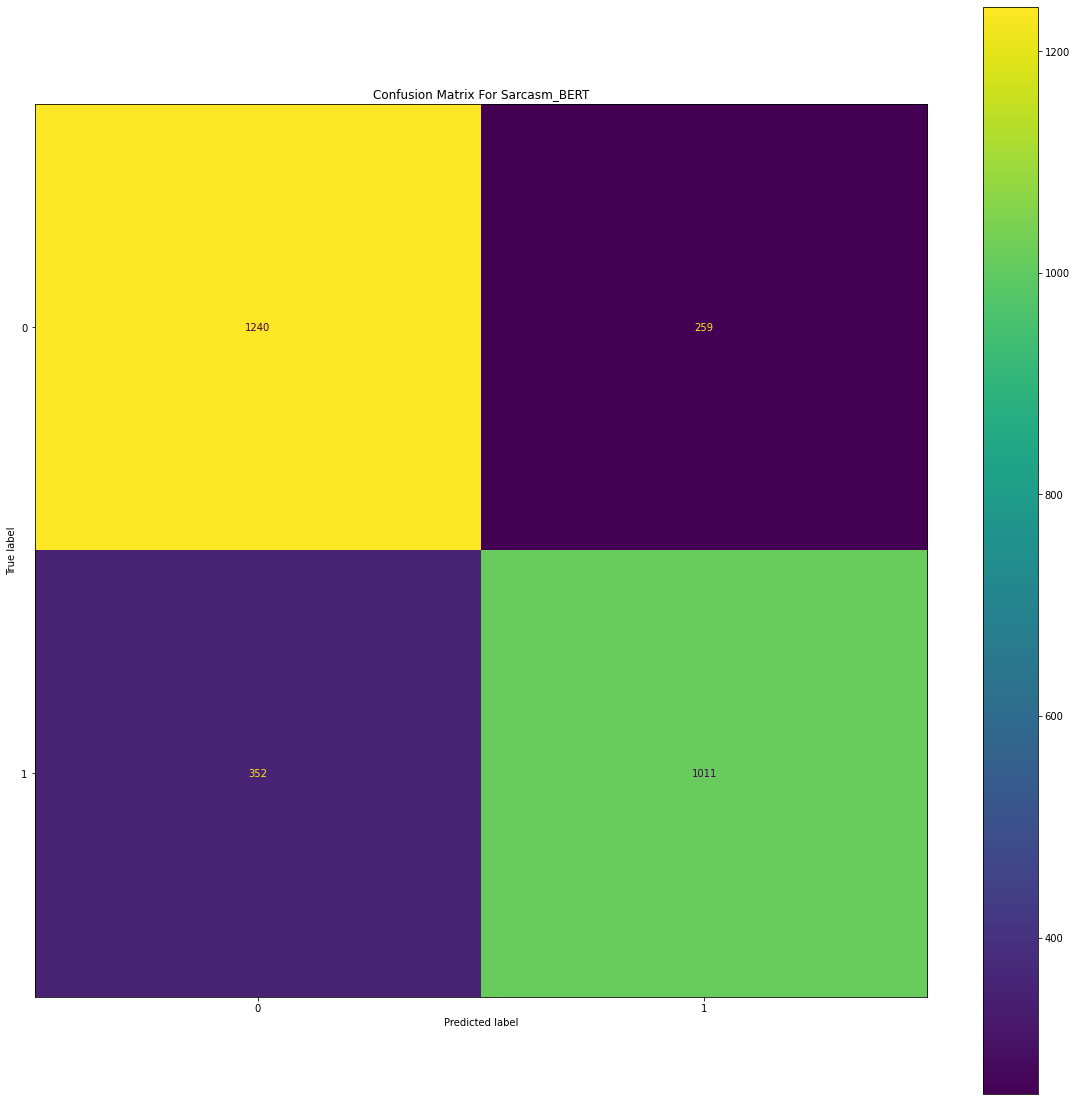

In [ ]:
#Confusion Matrix
conf_mat = confusion_matrix(final_lab, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
fig, ax = plt.subplots(figsize=(20,20))
plt.title('Confusion Matrix For Sarcasm_BERT')
disp.plot(ax = ax)

r_words = ["Sarcastic","Not Sarcastic"]
class_report = classification_report(final_lab,final_pred,target_names =r_words)
print('\033[1m'+'Precision, Recall and Accuracy for Headline Data:\n')
print(class_report)

In [ ]:
# #Optimizer and training
# Epochs = 1
# optimizer = AdamW(bert_model.parameters(),lr = 1e-3,eps = 1e-6)
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = 0,num_training_steps = len(trainloader)*Epochs)

# predictions = []
# labels = []

# final_loss = 0

# bert_model.train()

# for epoch in range(1, Epochs+1):
#   for batch in tqdm(trainloader,total = len(trainloader)):

#     labels.extend(batch['labels'].numpy().flatten().tolist())
#     # for key,value in batch.items():
#     #   batch = {key:value.type(torch.long).to(device)}
#     batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}


#     bert_model.zero_grad()

#     outputs = bert_model(batch['input_ids'],batch['attention_mask'])
#     print(len(outputs[1][1]))
#     loss,logits = outputs[:2]

#     final_loss += loss.item()

#     loss.backward()
#     optimizer.step()
#     scheduler.step()

#     logits = logits.detach().cpu().numpy()

#     predictions.extend(logits.argmax(axis = -1).flatten().tolist())

#   average_loss = final_loss/len(trainloader)